#### Grading Feedback 
- 50

# Example Project Notebook

## SB718

There are only 2 accepted ways to load data for your project, from a cloud service or Google drive.  If you load data from a cloud service like github, you don't have to follow this format. Keep in mind that the graders do not expect to have to perform any manual steps to load your data from a cloud service.  If we don't see these cells at the start of your notebook, we will assume you are loading your data from a cloud service.<br>
If you are loading data through Google drive, the following cells must be at the start of your notebook.  The naming scheme that we are requiring teams to use will allow us to run your code without having to modify your code.

In [ ]:
# The first code cell of your notebook shall include all needed imports to run your project code.  Note that
# there can be markdown cells above this cell.
import pandas as pd

In [ ]:
# # All data files shall be located in the following directory on 
# # your google drive: /content/drive/My Drive/ist718_data/data_groupN

# # The following provides 2 example file names and their full path names.  This example assumes the assigned
# # group name is group12.  The definitions in this cell must be used to load all data files.
# # This is only an example, change these definitions to match your file names.
# car_data_csv = '/content/drive/My Drive/ist718_data/data_group12/car_data.csv'
# engine_data_csv = '/content/drive/My Drive/ist718_data/data_group12/engine_data.csv'

In [ ]:
# # The third code cell of your notebook must contain code to mount your google drive and load the data files
# from google.colab import drive
# drive.mount('/content/drive')

# # You must use the definitions above to load your data.
# car_df = pd.read_csv(car_data_csv)
# engine_df = pd.read_csv(engine_data_csv)

In [ ]:
# Other code or markdown cells follow ...


In [ ]:
! git clone https://github.com/cylyu/ist718-project.git

Cloning into 'ist718-project'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
! ls

ist718-project	sample_data


## nb 718

In [ ]:
%%bash
pip install pyspark
# Download tweets.csv from github
# If the tweets.csv file does not exist in the colab environment
if [[ ! -f ./nyc-rolling-sales.csv ]]; then 
   # download tweets.csv file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/cylyu/ist718-project/main/nyc-rolling-sales.csv   
fi

# vefify tweets.csv exits in the colab env - should not print an error message
ls nyc-rolling-sales.csv

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=20681f9d66a0965989f876168add213602b9a9242bdcc5a80fbc88688bc6fabe
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
nyc-rolling-sales.csv


--2020-12-08 08:04:16--  https://raw.githubusercontent.com/cylyu/ist718-project/main/nyc-rolling-sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13625843 (13M) [text/plain]
Saving to: ‘nyc-rolling-sales.csv’

     0K .......... .......... .......... .......... ..........  0% 6.22M 2s
    50K .......... .......... .......... .......... ..........  0% 17.7M 1s
   100K .......... .......... .......... .......... ..........  1% 7.39M 2s
   150K .......... .......... .......... .......... ..........  1% 23.6M 1s
   200K .......... .......... .......... .......... ..........  1% 10.0M 1s
   250K .......... .......... .......... .......... ..........  2% 45.9M 1s
   300K .......... .......... .......... .......... ..........  2% 38.4M 1s
   350K .......... ...

In [ ]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
from pyspark.sql import types
from pyspark.sql.functions import *
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,lower
import numpy as np
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler,PCA,OneHotEncoder
from pyspark.sql.functions import concat, concat_ws
import pandas as pd
from pyspark.sql.types import DoubleType,IntegerType,TimestampType,DateType, StringType,LongType
spark = SparkSession.builder.master("local[*]").config("spark.memory.fraction", 0.8).config("spark.executor.memory", "12g").config("spark.driver.memory", "12g").config("spark.memory.offHeap.enabled",'true').config("spark.memory.offHeap.size","12g").getOrCreate()
sparkContext=spark.sparkContext
from pyspark.sql.functions import year, month, dayofmonth

In [ ]:
enable_grid_search = False

In [ ]:
nyc_rolling_sales_df = spark.read.csv("nyc-rolling-sales.csv", header=True, inferSchema=True)

In [ ]:
dup_row=nyc_rolling_sales_df\
    .groupby(['ADDRESS', 'NEIGHBORHOOD','SALE DATE','SALE PRICE']) \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False)

def sum_col(df, col):
    return df.select(fn.sum(col)).collect()[0][0]


print('number of duplicate rows: ',sum_col(dup_row,'count'),\
      'distinct rows of duplicate: ',dup_row.count(),'row needs to delete: ',sum_col(dup_row,'count')-dup_row.count())

number of duplicate rows:  3748 distinct rows of duplicate:  1225 row needs to delete:  2523


In [ ]:
#drop duplicate row 
nyc_rolling_sales_df=nyc_rolling_sales_df.drop_duplicates(subset=['ADDRESS', 'NEIGHBORHOOD','SALE DATE'])

## Data exploration

In [ ]:
#rename the column
df3=nyc_rolling_sales_df.withColumnRenamed('APARTMENT NUMBER','apartment_number').withColumnRenamed('SALE PRICE','sale_price').\
withColumnRenamed('SALE DATE','sale_date').\
withColumnRenamed('BUILDING CLASS AT TIME OF SALE','building_class_at_sale').\
withColumnRenamed('ZIP CODE','zipcode').\
withColumnRenamed('GROSS SQUARE FEET','gross_square_feet').\
withColumnRenamed('LAND SQUARE FEET','land_square_feet').\
withColumnRenamed('BOROUGH','borough')
df3.show(5)

+-----+-------+--------------+-----------------------+--------------------+-----+----+---------+-------------------------+--------------------+----------------+-------+-----------------+----------------+-----------+----------------+-----------------+----------+-------------------------+----------------------+----------+-------------------+
|  _c0|borough|  NEIGHBORHOOD|BUILDING CLASS CATEGORY|TAX CLASS AT PRESENT|BLOCK| LOT|EASE-MENT|BUILDING CLASS AT PRESENT|             ADDRESS|apartment_number|zipcode|RESIDENTIAL UNITS|COMMERCIAL UNITS|TOTAL UNITS|land_square_feet|gross_square_feet|YEAR BUILT|TAX CLASS AT TIME OF SALE|building_class_at_sale|sale_price|          sale_date|
+-----+-------+--------------+-----------------------+--------------------+-----+----+---------+-------------------------+--------------------+----------------+-------+-----------------+----------------+-----------+----------------+-----------------+----------+-------------------------+----------------------+------

In [ ]:
df3=df3.withColumn('building_age', 2020-col('YEAR BUILT')).drop("YEAR BUILT").filter(df3.sale_price != ' -  ').\
                      filter(df3.land_square_feet != ' -  ').\
                      filter(df3.gross_square_feet != ' -  ').\
         withColumn("sale_price",df3["sale_price"].cast(IntegerType())).\
         withColumn("gross_square_feet",df3["gross_square_feet"].cast(IntegerType())).\
         withColumn("sale_date",df3["sale_date"].cast(DateType())).\
         withColumn("land_square_feet",df3["land_square_feet"].cast(IntegerType())).\
         withColumn("price_per_sq_ft", col("sale_price") / col("gross_square_feet")).\
         withColumn('borough',fn.when(fn.col('borough')==1,'Manhatten').\
                                                     when(fn.col('borough')==2,'Bronx').\
                                                     when(fn.col('borough')==3,'Brooklyn').\
                                                     when(fn.col('borough')==4,'Queens').\
                                                     when(fn.col('borough')==5,'Staten Island').\
                                                     otherwise(fn.col("borough"))).where('sale_price != 0')


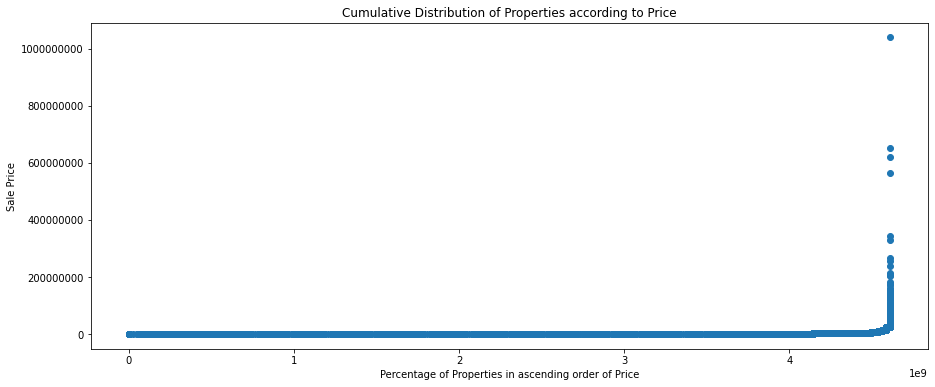

In [ ]:
#Set the size of the plot
plt.figure(figsize=(15,6))

from pyspark.sql.functions import monotonically_increasing_id 






#Get the data and format it
x = df3.select('sale_price').sort('sale_price')
df_index = x.select("*").withColumn("id", monotonically_increasing_id())

total_index=df_index.count()
price_pro=df_index.withColumn("property proportion",(col("id") +1)*100/total_index)
price_pro_pd=price_pro.toPandas()


# Plot the data and configure the settings
plt.plot(price_pro_pd['property proportion'],price_pro_pd['sale_price'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Properties according to Price')
plt.xlabel('Percentage of Properties in ascending order of Price')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


In [ ]:
df3= df3.where(df3.sale_price > 100000).where(df3.sale_price < 100000000)

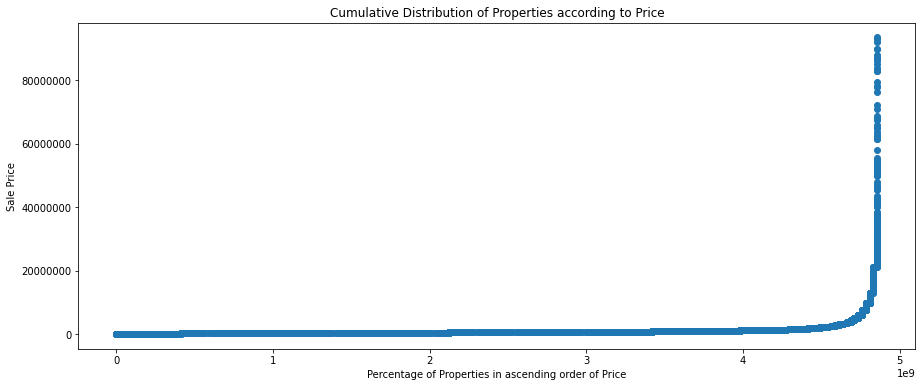

In [ ]:
#Set the size of the plot
plt.figure(figsize=(15,6))

from pyspark.sql.functions import monotonically_increasing_id 






#Get the data and format it
x = df3.select('sale_price').sort('sale_price')
df_index = x.select("*").withColumn("id", monotonically_increasing_id())

total_index=df_index.count()
price_pro=df_index.withColumn("property proportion",(col("id") +1)*100/total_index)
price_pro_pd=price_pro.toPandas()


# Plot the data and configure the settings
plt.plot(price_pro_pd['property proportion'],price_pro_pd['sale_price'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Properties according to Price')
plt.xlabel('Percentage of Properties in ascending order of Price')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


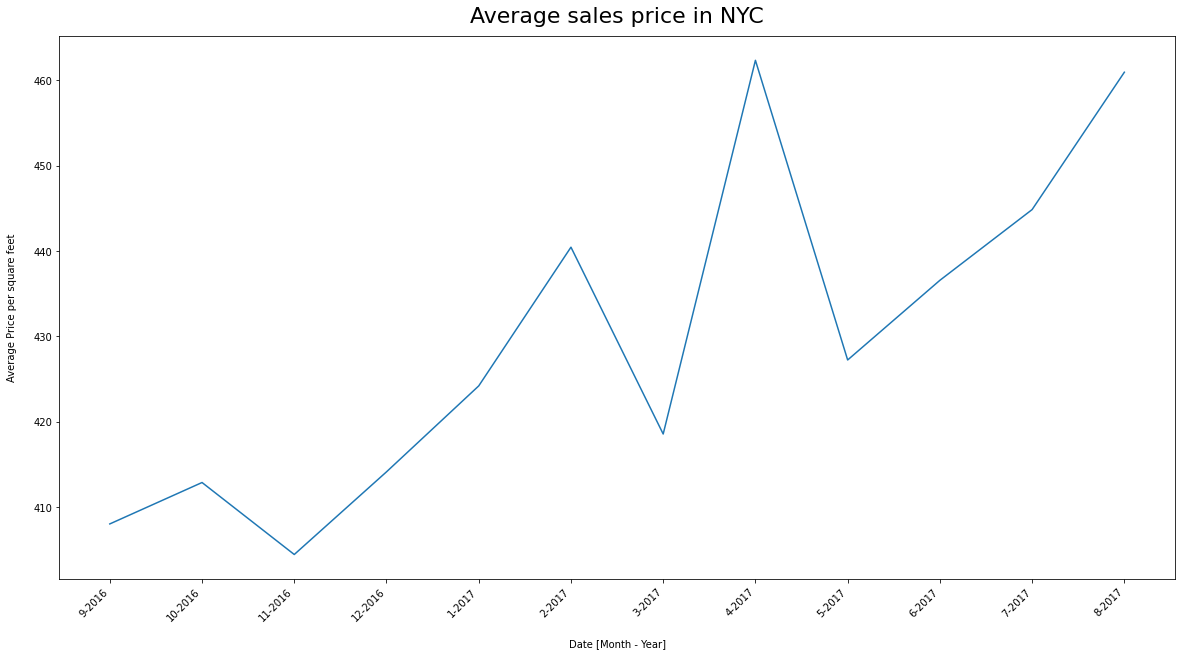

In [ ]:
date_df=df3.select("sale_date",
                                    "price_per_sq_ft",
    year("sale_date").alias('year'), 
    month("sale_date").alias('month'), 
    dayofmonth("sale_date").alias('day')
)

                                                
b=date_df.groupBy('month','year').avg('price_per_sq_ft')
b=b.withColumn("month_year", concat_ws("-",  b.month,b.year))
b_pd=b.sort('year', 'month').toPandas()
names = b_pd['month_year']
values =b_pd['avg(price_per_sq_ft)']

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(names, values)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.ylabel("Average Price per square feet", labelpad=16)

plt.xlabel("Date [Month - Year]", labelpad=16)
plt.title("Average sales price in NYC", y=1.013, fontsize=22)
plt.show()

In [ ]:
b_pd

,month,year,avg(price_per_sq_ft),month_year
0,9,2016,408.021423,9-2016
1,10,2016,412.874213,10-2016
2,11,2016,404.438350,11-2016
3,12,2016,414.125261,12-2016
4,1,2017,424.195818,1-2017
5,2,2017,440.453272,2-2017
6,3,2017,418.558657,3-2017
7,4,2017,462.352477,4-2017
8,5,2017,427.235114,5-2017
9,6,2017,436.571398,6-2017


In [ ]:
b.orderBy(['year','month'], ascending = True).show()

+-----+----+--------------------+----------+
|month|year|avg(price_per_sq_ft)|month_year|
+-----+----+--------------------+----------+
|    9|2016|  408.02142342239864|    9-2016|
|   10|2016|   412.8742131724808|   10-2016|
|   11|2016|   404.4383500586562|   11-2016|
|   12|2016|   414.1252607891815|   12-2016|
|    1|2017|   424.1958176533773|    1-2017|
|    2|2017|  440.45327247711936|    2-2017|
|    3|2017|  418.55865679180033|    3-2017|
|    4|2017|   462.3524768597377|    4-2017|
|    5|2017|   427.2351138940082|    5-2017|
|    6|2017|  436.57139792311045|    6-2017|
|    7|2017|   444.8610623223661|    7-2017|
|    8|2017|  460.95597056437447|    8-2017|
+-----+----+--------------------+----------+



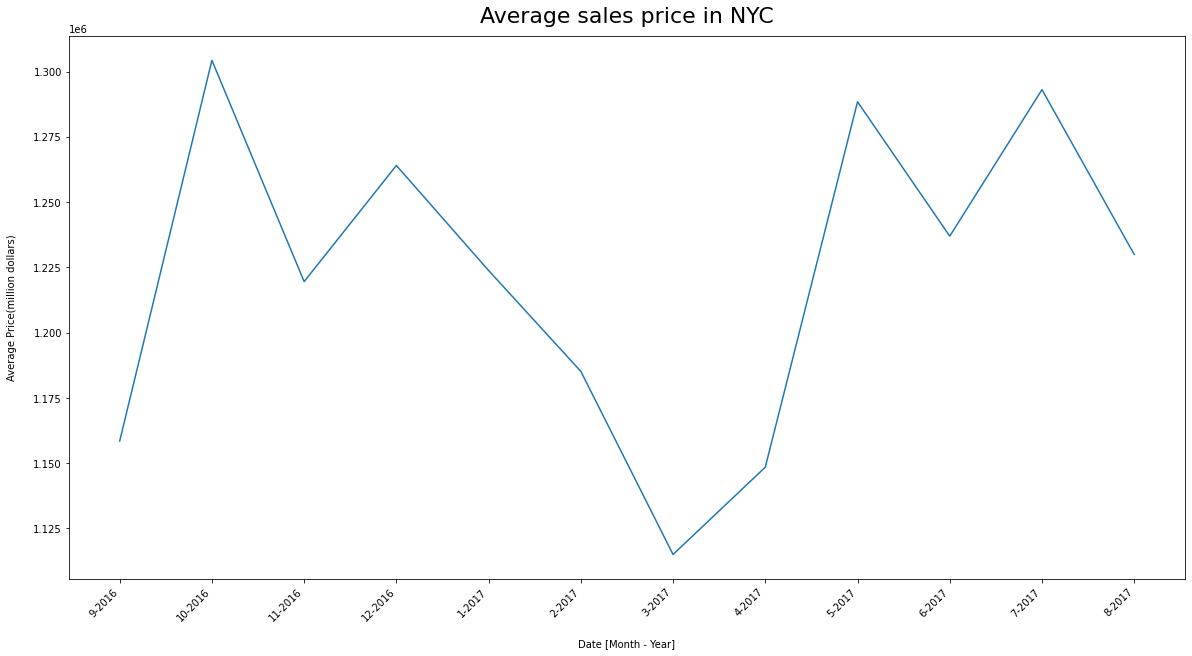

In [ ]:

date_df=df3.select("sale_date",
                                    "sale_price",
    year("sale_date").alias('year'), 
    month("sale_date").alias('month'), 
    dayofmonth("sale_date").alias('day')
)
# .\
# withColumn('month',fn.when(fn.col('month')==1,'Jan').\
#                                                      when(fn.col('month')==2,'Fed').\
#                                                      when(fn.col('month')==3,'Mar').\
#                                                      when(fn.col('month')==4,'Apr').\
#                                                      when(fn.col('month')==5,'Mar').\
#                                                      when(fn.col('month')==6,'Jun').\
#                                                      when(fn.col('month')==7,'Jul').\
#                                                      when(fn.col('month')==8,'Aug').\
#                                                      when(fn.col('month')==9,'Sep').\
#                                                      when(fn.col('month')==10,'Oct').\
#                                                      when(fn.col('month')==11,'Nov').\
#                                                      when(fn.col('month')==12,'Dec').\
#                                                      otherwise(fn.col("month")))
                                                
b=date_df.groupBy('month','year').avg('sale_price')
b=b.withColumn("month_year", concat_ws("-",  b.month,b.year)).orderBy(['year','month'], ascending = True)
b_pd=b.toPandas()
names = b_pd['month_year']
values =b_pd['avg(sale_price)']

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(names, values)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.ylabel("Average Price(million dollars)", labelpad=16)

plt.xlabel("Date [Month - Year]", labelpad=16)
plt.title("Average sales price in NYC", y=1.013, fontsize=22)
plt.show()


# b_pd.set_index('month_year')['avg(sale_price)'].plot(kind='line',
#                                                                                 figsize=(19, 10),
#                                                                                  color='cadetblue',
#                                                                                 rot=45)
# plt.title("Historical Count of Passengers Per Month", y=1.013, fontsize=22)
# axes= plt.axes()


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.10540926,        nan, 0.4       ],
             [0.10540926, 1.        ,        nan, 0.9486833 ],
             [       nan,        nan, 1.        ,        nan],
             [0.4       , 0.9486833 ,        nan, 1.        ]])


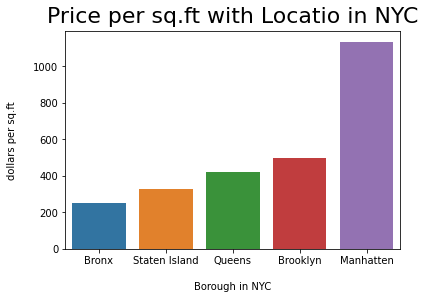

In [ ]:
borough_data=df3.groupby('borough').avg('price_per_sq_ft').toPandas().sort_values('avg(price_per_sq_ft)')
sns.barplot(x = 'borough',
            y='avg(price_per_sq_ft)',
              data=borough_data
)
plt.ylabel("dollars per sq.ft", labelpad=16)

plt.xlabel("Borough in NYC", labelpad=16)
plt.title("Price per sq.ft with Locatio in NYC", y=1.013, fontsize=22)
plt.show()

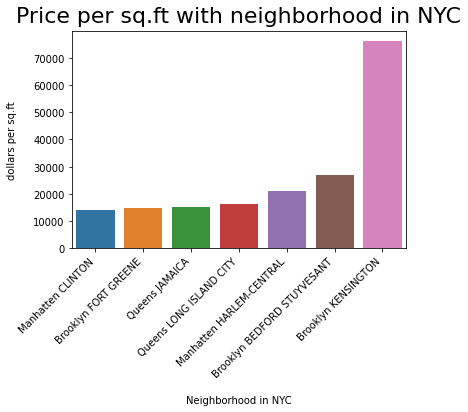

In [ ]:
neighborhood_data=df3.filter(df3.price_per_sq_ft >=10000).\
                                            groupby('NEIGHBORHOOD','borough').avg('price_per_sq_ft')
neighborhood_pd=neighborhood_data.withColumn("neigbor", concat_ws(" ",  neighborhood_data.borough,neighborhood_data.NEIGHBORHOOD)).\
                                  toPandas().sort_values('avg(price_per_sq_ft)')
sns.barplot(x = 'neigbor',
            y='avg(price_per_sq_ft)',
              data=neighborhood_pd
)
plt.ylabel("dollars per sq.ft", labelpad=16)

plt.xlabel("Neighborhood in NYC", labelpad=16)
plt.title("Price per sq.ft with neighborhood in NYC", y=1.013, fontsize=22)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

In [ ]:
nyc_sales_df=nyc_rolling_sales_df
nyc_pd = nyc_sales_df.toPandas()
nyc_pd['BUILDING CLASS AT TIME OF SALE'].unique()
print(len(nyc_pd['BUILDING CLASS AT TIME OF SALE'].unique()))
nyc_pd['BUILDING CLASS AT TIME OF SALE'].unique()

166


array(['R4', 'B3', 'A5', 'B1', 'B9', 'D4', 'A1', 'C0', 'R2', 'A2', 'A9',
       'B2', 'C6', 'R9', 'R3', 'S2', 'D7', 'C2', 'RP', 'RB', 'D0', 'C1',
       'G1', 'C7', 'R8', 'G7', 'R1', 'A3', 'V0', 'K2', 'RS', 'R6', 'C3',
       'A0', 'K4', 'RR', 'A4', 'G0', 'RG', 'E1', 'V1', 'S1', 'D1', 'C5',
       'K1', 'O4', 'F5', 'S9', 'G6', 'M4', 'A6', 'F9', 'P9', 'S5', 'H3',
       'S0', 'Z9', 'V2', 'C4', 'RH', 'S4', 'O2', 'N2', 'E2', 'O7', 'E9',
       'G2', 'O5', 'D5', 'F1', 'S3', 'M9', 'G9', 'RK', 'F4', 'D3', 'M1',
       'Z0', 'V3', 'W9', 'E7', 'O6', 'D9', 'L8', 'W1', 'J4', 'W2', 'I7',
       'H2', 'O9', 'W8', 'H8', 'K7', 'O1', 'D6', 'Q9', 'K9', 'G8', 'K5',
       'G4', 'O8', 'RA', 'RW', 'L1', 'H4', 'W4', 'K3', 'I5', 'R5', 'J9',
       'C9', 'P5', 'I1', 'K6', 'P8', 'I6', 'V9', 'I4', 'M3', 'Q1', 'W3',
       'G5', 'D2', 'I9', 'C8', 'R0', 'GU', 'RT', 'H1', 'A7', 'L9', 'U6',
       'D8', 'HB', 'F2', 'N9', 'O3', 'P2', 'GW', 'HR', 'U1', 'J5', 'I3',
       'P6', 'G3', 'W6', 'Y1', 'T2', 'Z2', 'J1', 'J

In [ ]:
plt_df = nyc_sales_df.groupby('BUILDING CLASS AT TIME OF SALE').agg(avg('SALE PRICE'),count("*"))
plt_df.show()

+------------------------------+--------------------+--------+
|BUILDING CLASS AT TIME OF SALE|     avg(SALE PRICE)|count(1)|
+------------------------------+--------------------+--------+
|                            Z9|  3243628.5409836066|     140|
|                            RG|  305466.39366515836|     281|
|                            C6|  472013.59521943575|    2743|
|                            A9|   536916.4502369668|    1395|
|                            H6|             7.535E7|       2|
|                            D7|2.1996417849056605E7|      64|
|                            R6|   973033.7923497268|     187|
|                            D5|2.9869796470588237E7|      21|
|                            W6|                 0.0|       2|
|                            V3|  16833.333333333332|       8|
|                            F2|           2618750.0|       5|
|                            R8|  3667276.8292682925|      46|
|                            A6|  219079.14285714287|  

Text(0.5, 1.0, 'average sale price of building class')

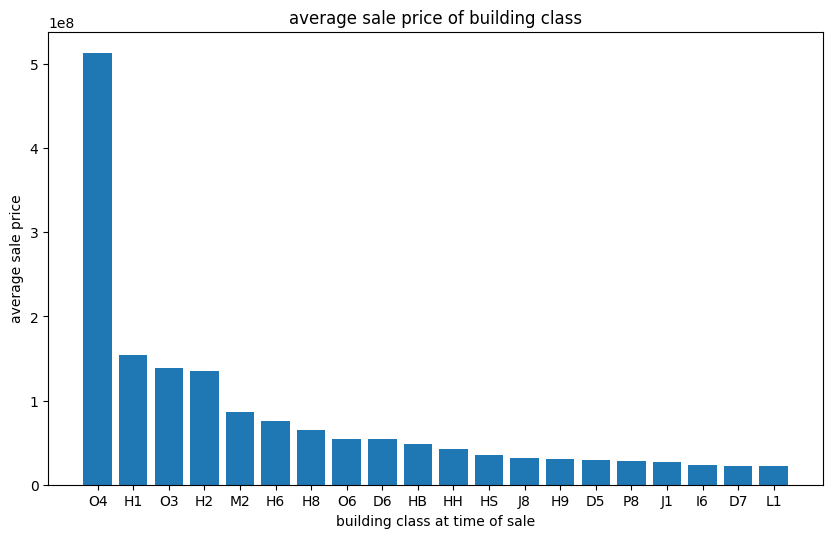

In [ ]:

df1 = plt_df.orderBy('avg(SALE PRICE)', ascending = False)
plt1 = df1.toPandas()
plt1_20 = plt1.head(20)
plt.figure(num=None, figsize=(10, 6), dpi = 100)
plt.bar(x = 'BUILDING CLASS AT TIME OF SALE', height = 'avg(SALE PRICE)', data = plt1_20)
plt.ylabel('average sale price')
plt.xlabel('building class at time of sale')
plt.title('average sale price of building class')

Text(0.5, 1.0, 'total number of sold building by building class')

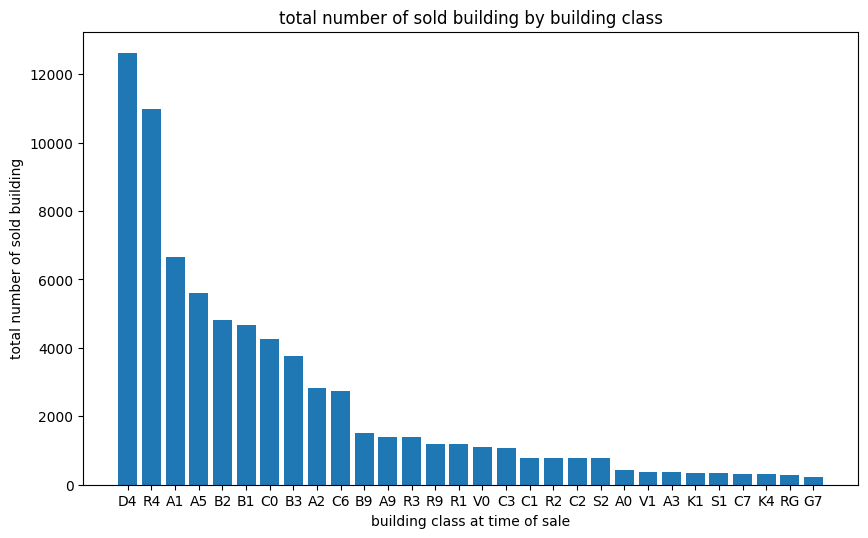

In [ ]:
df2 = plt_df.orderBy('count(1)', ascending = False)
plt2 = df2.toPandas()
plt2_30 = plt2.head(30)
plt.figure(num=None, figsize=(10, 6), dpi = 100)
plt.bar(x = 'BUILDING CLASS AT TIME OF SALE', height = 'count(1)', data = plt2_30)
plt.ylabel('total number of sold building')
plt.xlabel('building class at time of sale')
plt.title('total number of sold building by building class')

## LinearRegression

In [ ]:
# choose some columns as feature columns 
columns = ['borough', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'land_square_feet', 'gross_square_feet', 'building_age',
       'sale_price']
nyc_property_df_lr = df3.select(columns)
nyc_property_df_lr = nyc_property_df_lr.filter(((col('RESIDENTIAL UNITS') > 0) | (col('COMMERCIAL UNITS') > 0)) & \
                                             (col('gross_square_feet') > 0) &  \
                                             (col('building_age') < 400) &\
                                             (col('land_square_feet') > 100))

In [ ]:
import pyspark.sql.functions as F 
# Convert categorical variables into dummy variables
borough_catag = list(nyc_property_df_lr.select('borough').distinct().toPandas()['borough'])
borough_dummy = [F.when(F.col('borough') == cata,1).otherwise(0)\
            .alias("borough_" + str(cata)) for cata in borough_catag]
class_catag = list(nyc_property_df_lr.select('BUILDING CLASS CATEGORY').distinct().toPandas()['BUILDING CLASS CATEGORY'])
class_dummy = [F.when(F.col('BUILDING CLASS CATEGORY') == cata,1).otherwise(0)\
            .alias("CLASS_" + str(cata)[:2]) for cata in class_catag]
neighborhood_catag = list(nyc_property_df_lr.select('NEIGHBORHOOD').distinct().toPandas()['NEIGHBORHOOD'])
neighborhood_dummy = [F.when(F.col('NEIGHBORHOOD') == cata,1).otherwise(0)\
            .alias("neighborhood_" + cata.replace(' ', '_').replace('-', '_').replace('.', '').lower()) for cata in neighborhood_catag]
nyc_property_df_lr1 = nyc_property_df_lr.select(borough_dummy+neighborhood_dummy+class_dummy+nyc_property_df_lr.columns)
boroughs = nyc_property_df_lr1.columns[:5]
# Create new variables by multiplying borough variables by land_square_feet and gross_square_feet variables
for i in range(len(borough_catag)):
  nyc_property_df_lr1 = nyc_property_df_lr1.withColumn(boroughs[i]+"*"+"land_square_feet", col(boroughs[i])*col("land_square_feet"))
  nyc_property_df_lr1 = nyc_property_df_lr1.withColumn(boroughs[i]+"*"+"gross_square_feet", col(boroughs[i])*col("gross_square_feet"))

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
# Split training and testing dataset
nyc_property_train_df, nyc_property_test_df = nyc_property_df_lr1.randomSplit([0.7, 0.3])

featureCols = nyc_property_df_lr1.columns
featureCols = [n for n in featureCols if n not in ['borough', 'NEIGHBORHOOD','BUILDING CLASS CATEGORY', 'sale_price']]
# build linear regression model
va = VectorAssembler(inputCols=featureCols, outputCol="features")
lr = LinearRegression(featuresCol = 'features', labelCol='sale_price')

nyc_property_pipe_lr = Pipeline(stages= [va, lr])
nyc_property_model_lr = nyc_property_pipe_lr.fit(nyc_property_train_df)
nyc_property_predictions_lr = nyc_property_model_lr.transform(nyc_property_test_df)
price_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="sale_price", metricName="mse")
price_error_lr = price_evaluator.evaluate(nyc_property_predictions_lr)
print("Mean Squared Error (MSE) of linear regression on test data = %g" % price_error_lr)

Mean Squared Error (MSE) of linear regression on test data = 8.63723e+12


In [ ]:
# Determine the most important predictor order
from pyspark.ml.feature import StandardScaler
import pandas as pd
sc = StandardScaler(withMean=True, inputCol='features')
inference_pipe = Pipeline(stages= [va, sc, lr])
model_scaler_lr = inference_pipe.fit(nyc_property_train_df)

# the coefficient column contains the coefficient names and the value column 
# contains the regression model coefficient absolute values
coefficients_df_lr = pd.DataFrame(
    {'coefficient': featureCols,
     'value': [np.abs(x) for x in list(model_scaler_lr.stages[-1].coefficients)]
    }).sort_values('value', ascending=False)
display(coefficients_df_lr.head(10))

,coefficient,value
105,neighborhood_tribeca,8.028101e+07
246,neighborhood_downtown_fulton_mall,3.571232e+07
196,neighborhood_midtown_cbd,2.932214e+07
264,CLASS_31,2.673393e+07
253,neighborhood_financial,2.663766e+07
95,neighborhood_downtown_fulton_ferry,2.519292e+07
34,neighborhood_midtown_west,2.386830e+07
277,CLASS_10,2.114723e+07
270,CLASS_34,1.914089e+07
26,neighborhood_soho,1.629695e+07


(0.0, 100000000.0)

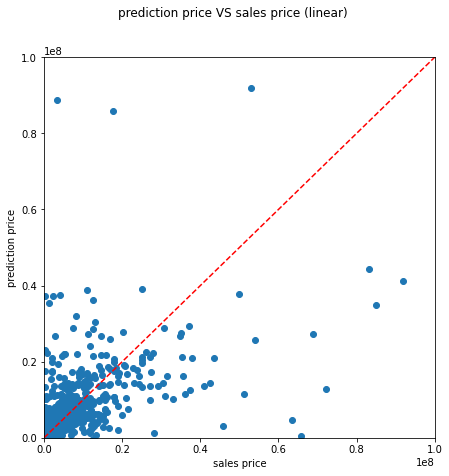

In [ ]:
sales_price_lr = list(nyc_property_predictions_lr.select('sale_price').toPandas()['sale_price'])
prediction_price_lr = list(nyc_property_predictions_lr.select('prediction').toPandas()['prediction'])
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.plot([0, 100000000], [0, 100000000], 'r--')
ax.scatter(sales_price_lr,prediction_price_lr)

fig.suptitle("prediction price VS sales price (linear)")
ax.set_xlabel("sales price")
ax.set_ylabel("prediction price")
plt.xlim(0, 100000000)
plt.ylim(0, 100000000)

## Random forest






































In [ ]:
# choose feature columns for random forest model
featureCols_2 = [i for i in featureCols[:-10] if not i.startswith('neigh')]
featureCols_3 = featureCols_2 + ['sale_price']
nyc_property_df_rf = nyc_property_df_lr1.select(featureCols_3)
va_1 = VectorAssembler(inputCols=featureCols_2, outputCol="features")
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
# build random forest model
training_sample_df, validation_sample_df, testing_sample_df = nyc_property_df_rf.sample(False, 0.1, 1).randomSplit([0.6, 0.3, 0.1], seed=0)
rfr = RandomForestRegressor(labelCol="sale_price", featuresCol="features")
if enable_grid_search:
  paramGrid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 30, 50]) \
    .addGrid(rfr.maxDepth, [10, 15]) \
    .build()
  rf_pipe = Pipeline(stages=[va_1, rfr])
  # sample the dataset to minimize calculatation
  all_models = []
  for j in range(len(paramGrid)):
    print("Fitting model {}".format(j+1))
    model = rf_pipe.fit(training_sample_df, paramGrid[j])
    all_models.append(model)
  mses = [price_evaluator.evaluate(m.transform(validation_sample_df)) for m in all_models]
  print("mses are:", mses)
  print("The lowest mse is %f with grid %d." % (np.min(mses), mses.index(np.min(mses))))
  print("Best NumTrees is {}.".format(list(paramGrid[mses.index(np.min(mses))].values())[0]))
  print("Best MaxDepth is {}.".format(list(paramGrid[mses.index(np.min(mses))].values())[1]))

In [ ]:
# Create a pipeline that hard codes the tuning parameters from the best model found by the grid search above.
best_pipe_rf = Pipeline(stages=[va_1, RandomForestRegressor(labelCol="sale_price", featuresCol="features",
                                                  maxDepth = 10, numTrees = 30)])
best_model_rf = best_pipe_rf.fit(nyc_property_train_df)
nyc_property_predictions_rf = best_model_rf.transform(nyc_property_test_df)
price_error_rf = price_evaluator.evaluate(nyc_property_predictions_rf)
print("Mean Squared Error (MSE) of random forest on test data = %g" % price_error_rf)
# Determine the most important predictor order
rf_feature_importance = pd.DataFrame(
    {'feature': best_model_rf.stages[0].getInputCols(),
     'importance': best_model_rf.stages[-1].featureImportances
    }).sort_values('importance', ascending=False)
display(rf_feature_importance.head(10))

Mean Squared Error (MSE) of random forest on test data = 6.74687e+12


,feature,importance
36,gross_square_feet,0.312263
34,COMMERCIAL UNITS,0.112309
3,borough_Manhatten,0.107113
37,building_age,0.082356
33,RESIDENTIAL UNITS,0.078201
35,land_square_feet,0.077565
29,CLASS_26,0.037783
11,CLASS_08,0.030542
20,CLASS_21,0.017666
25,CLASS_07,0.017477


(0.0, 100000000.0)

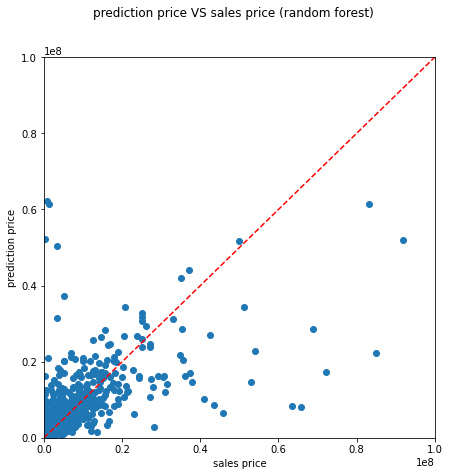

In [ ]:
sales_price_1 = list(nyc_property_predictions_rf.select('sale_price').toPandas()['sale_price'])
prediction_price_1 = list(nyc_property_predictions_rf.select('prediction').toPandas()['prediction'])

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.plot([0, 100000000], [0, 100000000], 'r--')
ax.scatter(sales_price_1,prediction_price_1)

fig.suptitle("prediction price VS sales price (random forest)")
ax.set_xlabel("sales price")
ax.set_ylabel("prediction price")
plt.xlim(0, 100000000)
plt.ylim(0, 100000000)

## GBT MODEL

In [ ]:
# preprocessing
df2 = nyc_rolling_sales_df.dropna(thresh=3,subset=('SALE PRICE', 'BUILDING CLASS CATEGORY', 'YEAR BUILT'))
df2 = df2.withColumn('SALE PRICE', translate('SALE PRICE', '-', '0'))
df2=df2.withColumnRenamed('SALE PRICE', 'price')
df2=df2.where("price!=0")
from pyspark.sql.types import FloatType
df2 = df2.withColumn('TOTAL UNITS', df2['TOTAL UNITS'].cast(FloatType()))
df2 = df2.withColumn('LAND SQUARE FEET', df2['LAND SQUARE FEET'].cast(FloatType()))
df2 = df2.withColumn('GROSS SQUARE FEET', df2['GROSS SQUARE FEET'].cast(FloatType()))
df2 = df2.withColumn('YEAR BUILT', df2['YEAR BUILT'].cast(FloatType()))
df2 = df2.withColumn('price', df2['price'].cast(FloatType()))
df2 = df2.dropna(thresh=5,subset=('TOTAL UNITS', 'LAND SQUARE FEET',	'GROSS SQUARE FEET',	'YEAR BUILT', 'price'))

Pipeline

In [ ]:
train, test = df2.randomSplit([8.0, 2.0])

va = feature.VectorAssembler(inputCols=['TOTAL UNITS', 'LAND SQUARE FEET',	'GROSS SQUARE FEET',	'YEAR BUILT'], outputCol='features')
gbt = regression.GBTRegressor(featuresCol='features', labelCol='price', maxIter=50, maxDepth=10, seed=42)

pipe = Pipeline(stages=[va, gbt])

model_gbt = pipe.fit(train)
gbt_prediction = model_gbt.transform(test)


In [ ]:
evaluator = evaluation.RegressionEvaluator(predictionCol='prediction', labelCol='price', metricName='mse')
evaluator.evaluate(gbt_prediction)

111920295613732.22

In [ ]:
df_stats = gbt_prediction.select(
    mean(col('price')).alias('mean')
).collect()
df_stats

In [ ]:
import matplotlib.pyplot as plt

gbt = gbt_prediction.toPandas()

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.plot([0, 100000000], [0, 100000000], 'r--')
ax.scatter(gbt['price'], gbt['prediction'])

fig.suptitle("prediction price VS sales price (GBT)")
ax.set_xlabel("sales price")
ax.set_ylabel("prediction price")
plt.xlim(0, 100000000)
plt.ylim(0, 100000000)